In [0]:
%tensorflow_version 2.x   #切換版本跟輸入套件

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Import some useful packages
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

# 下載mnist資料集      

In [0]:
# Load dataset
(X_train, y_train0), (X_test, y_test0) = datasets.fashion_mnist.load_data()

# Reshape size
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Normalize the range of featurs
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

4423680/4422102 [==============================] - 0s 0us/step


# atuoencoder

In [0]:
x = Input(shape=(784,))

enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid')

# Define latent repre. of x
z = enc_2(enc_1(x))

dec_2 = Dense(100, activation='sigmoid')
dec_2 = Dense(400, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

x_hat = dec_1(dec_2(z))

In [0]:
autoencoder = Model(x, x_hat)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
_________________________________________________________________
dense_3 (Dense)              (None, 400)               1200      
_________________________________________________________________
dense_4 (Dense)              (None, 784)               314384    
Total params: 394,286
Trainable params: 394,286
Non-trainable params: 0
_________________________________________________________________


In [0]:
autoencoder.compile(loss='mse',
                    optimizer=Adam(5e-3),
                    metrics=['mae']
                    )

# autoencoder.load_weights('autoencoder_mse_mae_weights.h5')

In [0]:
autoencoder.fit(X_train, X_train, 
                batch_size=512, 
                epochs=20, 
                validation_data=(X_test, X_test)
                )

# autoencoder.save_weights('autoencoder_mse_mae_weights.h5')   #開始訓練

Epoch 1/20
118/118 [==============================] - 4s 33ms/step - loss: 0.0785 - mae: 0.2045 - val_loss: 0.0579 - val_mae: 0.1700
Epoch 2/20
118/118 [==============================] - 4s 32ms/step - loss: 0.0495 - mae: 0.1523 - val_loss: 0.0460 - val_mae: 0.1442
Epoch 3/20
118/118 [==============================] - 4s 32ms/step - loss: 0.0457 - mae: 0.1429 - val_loss: 0.0449 - val_mae: 0.1417
Epoch 4/20
118/118 [==============================] - 4s 33ms/step - loss: 0.0446 - mae: 0.1409 - val_loss: 0.0444 - val_mae: 0.1408
Epoch 5/20
118/118 [==============================] - 4s 34ms/step - loss: 0.0442 - mae: 0.1398 - val_loss: 0.0438 - val_mae: 0.1395
Epoch 6/20
118/118 [==============================] - 4s 33ms/step - loss: 0.0438 - mae: 0.1387 - val_loss: 0.0434 - val_mae: 0.1379
Epoch 7/20
118/118 [==============================] - 4s 32ms/step - loss: 0.0434 - mae: 0.1376 - val_loss: 0.0429 - val_mae: 0.1368
Epoch 8/20
118/118 [==============================] - 4s 32ms/step - 

# 視覺化 資料還原與還原誤差

In [0]:
def reconstructed_img(idx):
    # Prepare image to be reconstructed
    X = X_train[idx:idx+1]
    y = y_train0[idx]
    X_hat = autoencoder.predict(X)

    # Reshape for plotting  
    X = X.reshape(28, 28)
    X_hat = X_hat.reshape(28, 28)
    rec_error = np.abs(X-X_hat)

    # Prepare a canvas for plotting
    plt.figure(figsize=(12, 9))
    ax1 = plt.subplot2grid((2,3),(0,0))
    ax2 = plt.subplot2grid((2,3),(0,1))
    ax3 = plt.subplot2grid((2,3),(0,2))
    ax4 = plt.subplot2grid((2,3),(1,0), colspan=3)

    # Plot raw image
    ax1.imshow(X, 'Greys')
    ax1.set_title(f'Number: {y}')

    # Plot reconstructed image
    ax2.imshow(X_hat, 'Greys')
    ax2.set_title('Reconstructed Image')

    # Plot reconstruction error
    ax3.imshow(rec_error, 'Greys')
    ax3.set_title('Reconstructed Error')
    ax4.hist(rec_error.flatten(), bins=20, rwidth=0.5)
    ax4.set_title('Histogram of Reconstructed Error')

In [0]:
interact(reconstructed_img, idx=IntSlider(min=0, max=X_train.shape[0], step=1, value=3));

interactive(children=(IntSlider(value=3, description='idx', max=60000), Output()), _dom_classes=('widget-inter…

# Encoder & Decoder

In [0]:
Encoder = Model(x, z)
Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [0]:
z_input = Input(shape=(2,))
Decoder = Model(z_input, dec_1(dec_2(z_input)))

Decoder.summary()   #Decoder 是由  h  開始，因此，我們先準備一個與  h  相同大小的 Input，並餵進 dec_2 及 dec_1 中即可

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 400)               1200      
_________________________________________________________________
dense_4 (Dense)              (None, 784)               314384    
Total params: 315,584
Trainable params: 315,584
Non-trainable params: 0
_________________________________________________________________


# 視覺化Encoder

In [0]:
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {Encoder.predict(X_train[idx: idx+1]).squeeze()}")

第 10216 圖的 latent 表示為 [0.49072546 0.3634936 ]


In [0]:
indices = np.random.randint(X_train.shape[0], size=3000)

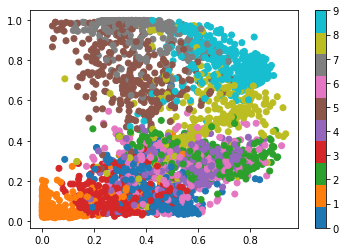

In [0]:
latents = Encoder.predict(X_train[indices])
plt.scatter(latents[:, 0], latents[:, 1], c=y_train0[indices], cmap="tab10")
plt.colorbar()
plt.show()

# 視覺化Decoder 在  [0,1]×[0,1]  這個單位正方形內均勻取樣  15∗15  個點，並將這  225  個平面上的點，透過 Decoder 進行圖片的還原。

In [0]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [0]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

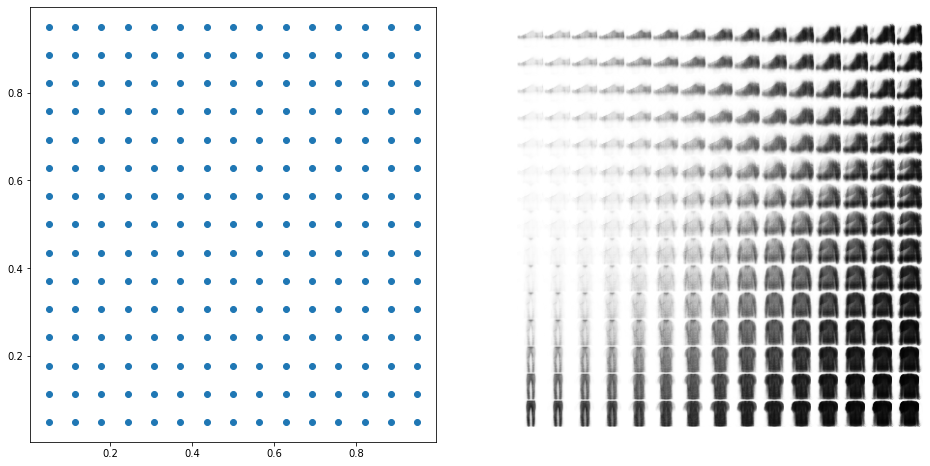

In [0]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XX, YY = np.meshgrid(grid_x, grid_y)
plt.scatter(XX, YY)

plt.subplot(1, 2, 2)
plt.imshow(figure, cmap='Greys')
plt.axis('off')
plt.show()

### 由於變異數恆正的特性，我們可以下面是以學習取對數後的變異數 (log-variance)。

## VAE 的建立
為了避免混淆，我們重新定義所有變數，首先，我們定義 Encoder 上的三個神經網路層



In [0]:
enc_1 = Dense(100, activation='sigmoid')
# enc_2 = Dense(2, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_2 = Dense(400, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [0]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

定義抽樣函數並透過 Lambda 將其轉換成 Keras layer。

透過  X∼N(0,1)⇒μ+σX∼N(μ,σ2)  和  σ=elogσ22 ，我們透過以下方式定義抽樣函數。

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [0]:
# Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [0]:
# Define Decoder part of VAE
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(z_input))

In [0]:
x_hat = dec_1(dec_2(z))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100)          78500       input_3[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            202         dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            202         dense_5[0][0]                    
____________________________________________________________________________________________

In [0]:
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

# Train VAE

In [0]:
VAE.compile(optimizer=Adam())

# VAE.load_weights('VAE_handwriting_model_weights.h5')

In [0]:
VAE.fit(X_train, X_train, 
        batch_size=256, 
        epochs=20)

VAE.save_weights('VAE_handwriting_model_weights.h5')

Epoch 1/20
235/235 [==============================] - 4s 18ms/step - loss: 59.7599
Epoch 2/20
235/235 [==============================] - 4s 18ms/step - loss: 42.4740
Epoch 3/20
235/235 [==============================] - 4s 18ms/step - loss: 39.4695
Epoch 4/20
235/235 [==============================] - 4s 17ms/step - loss: 39.1618
Epoch 5/20
235/235 [==============================] - 4s 17ms/step - loss: 39.0530
Epoch 6/20
235/235 [==============================] - 4s 17ms/step - loss: 38.9267
Epoch 7/20
235/235 [==============================] - 4s 18ms/step - loss: 38.7952
Epoch 8/20
235/235 [==============================] - 4s 17ms/step - loss: 38.5000
Epoch 9/20
235/235 [==============================] - 4s 17ms/step - loss: 37.7669
Epoch 10/20
235/235 [==============================] - 4s 17ms/step - loss: 36.5796
Epoch 11/20
235/235 [==============================] - 4s 18ms/step - loss: 35.7551
Epoch 12/20
235/235 [==============================] - 4s 18ms/step - loss: 35.2482
E

# VAE視覺化呈現
與 Autoencoder 一樣，我們來視覺化 VAE 上的 Encoder 跟 Decoder

# VAE: x↦Enc(μ,σ2)↦Samplingh↦Decx^
# Encoder: x↦Enc μ
# Decoder: h↦Dec x

In [0]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [0]:
VAE_Decoder = Model(z_input, dec_1(dec_2(z_input)))

VAE_Decoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_9 (Dense)              (None, 400)               1200      
_________________________________________________________________
dense_10 (Dense)             (None, 784)               314384    
Total params: 315,584
Trainable params: 315,584
Non-trainable params: 0
_________________________________________________________________


# Encoder 視覺化呈現

In [0]:
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(X_train[idx: idx+1]).squeeze()}")

第 39330 圖的 latent 表示為 [0.22965498 0.5030638 ]


In [0]:
VAE_latents = VAE_Encoder.predict(X_train[indices])

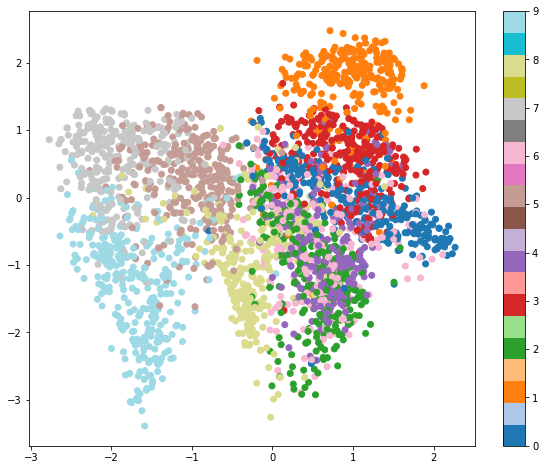

In [0]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

# Decoder 視覺化呈現

In [0]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [0]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

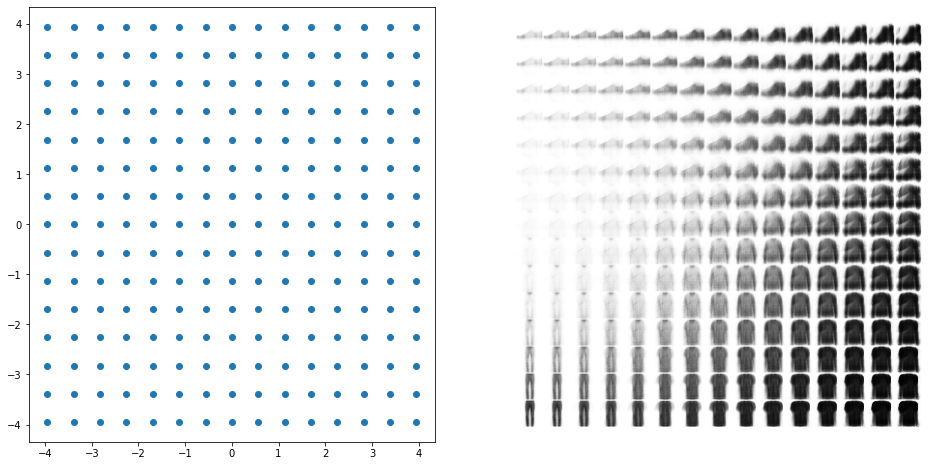

In [0]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(figure, cmap='Greys')
plt.axis('off')
plt.show()

# AutoEncoder 跟 Encoder 比較

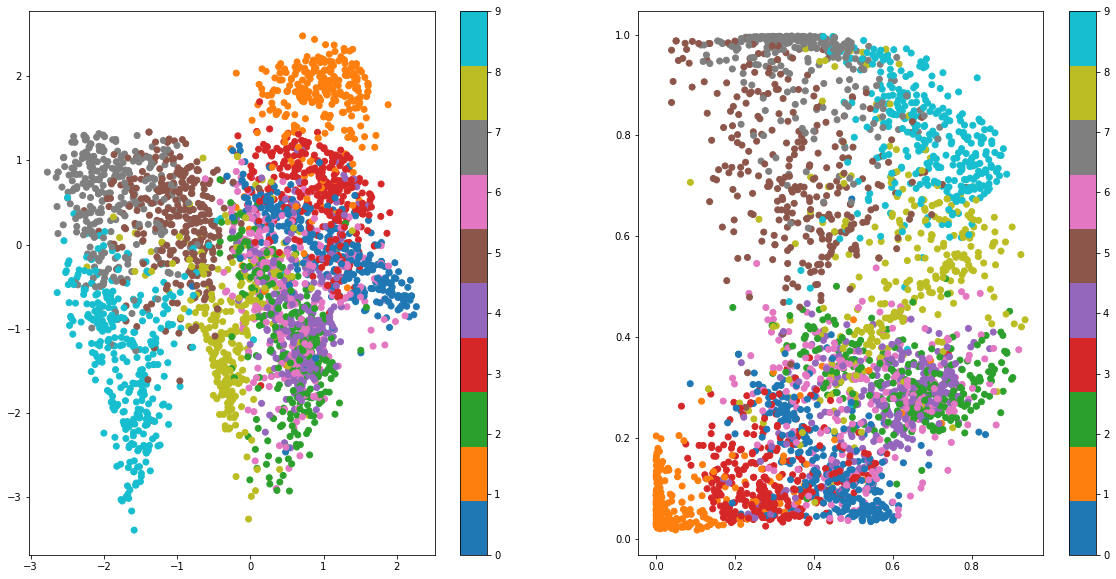

In [0]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab10')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(latents[:, 0], latents[:, 1], c=y_train0[indices], cmap="tab10")
plt.colorbar()
plt.show()

# 動態比較

In [0]:
idx_1, idx_2 = np.random.randint(X_train.shape[0], size=2)

In [0]:
def inBetween(t):
    data_0 = X_train[idx_1].reshape(28, 28)
    data_1 = X_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(X_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(X_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

In [0]:
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween>